# 1.0 Import

In [3]:
#Load and edit dataframe
import numpy as np
import pandas as pd


# Data Visualization
import seaborn           as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Select Train and Test
from sklearn.model_selection import train_test_split

# ML - Algoritms
from sklearn.preprocessing   import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

import warnings 
warnings.filterwarnings( 'ignore' ) 

## Load DataSet

In [4]:
df = pd.read_csv('../data/all_b3_bovespa.csv')

In [5]:
df_petro = df.copy()

# Data Analysis


In [6]:
print(f'nº of columns: {df_petro.shape[0]}, nº of rows:{df_petro.shape[1]}')

nº of columns: 733407, nº of rows:10


In [7]:
df_petro.dtypes

data_pregao          object
codbdi              float64
sigla_acao           object
nome_acao            object
preco_abertura      float64
preco_maximo        float64
preco_minimo        float64
preco_fechamento    float64
qtd_negocios          int64
volume_negocios       int64
dtype: object

In [8]:
a = df_petro[df_petro['sigla_acao']=='PETR4']
a

,data_pregao,codbdi,sigla_acao,nome_acao,preco_abertura,preco_maximo,preco_minimo,preco_fechamento,qtd_negocios,volume_negocios
213,2015-01-02,2.0,PETR4,PETROBRAS,9.99,9.99,9.36,9.36,48837200,4
530,2015-01-05,2.0,PETR4,PETROBRAS,9.14,9.19,8.58,8.61,77077300,6
829,2015-01-06,2.0,PETR4,PETROBRAS,8.71,8.83,8.04,8.33,84023400,7
1138,2015-01-07,2.0,PETR4,PETROBRAS,8.56,8.73,8.36,8.67,85531000,7
1450,2015-01-08,2.0,PETR4,PETROBRAS,8.79,9.39,8.74,9.18,82735700,7
...,...,...,...,...,...,...,...,...,...,...
704613,2021-12-23,2.0,PETR4,PETROBRAS,28.33,28.42,28.15,28.33,28713600,8
704614,2021-12-27,2.0,PETR4,PETROBRAS,28.32,28.78,28.15,28.75,44227900,12
704615,2021-12-28,2.0,PETR4,PETROBRAS,29.01,29.28,28.70,28.78,30688100,8
704616,2021-12-29,2.0,PETR4,PETROBRAS,28.70,28.90,28.42,28.54,35508400,10


# Data transformation

In [9]:
df_petro['data_pregao'] = pd.to_datetime(df_petro['data_pregao'], format='%Y-%m-%d')

In [10]:
df_petro.dtypes

data_pregao         datetime64[ns]
codbdi                     float64
sigla_acao                  object
nome_acao                   object
preco_abertura             float64
preco_maximo               float64
preco_minimo               float64
preco_fechamento           float64
qtd_negocios                 int64
volume_negocios              int64
dtype: object

# Select only one share to predict

In [11]:
# Filter share_data
df_petro = df[df['sigla_acao']=='PETR4']
print(f'nº of rows: {df_petro.shape[0]}, nº of columns:{df_petro.shape[1]}')

nº of rows: 1730, nº of columns:10


In [12]:
df_petro_cls = df_petro[['data_pregao', 'preco_fechamento']]
df_petro_cls.tail()

,data_pregao,preco_fechamento
704613,2021-12-23,28.33
704614,2021-12-27,28.75
704615,2021-12-28,28.78
704616,2021-12-29,28.54
704617,2021-12-30,28.45


In [13]:
# set to index with date
df_petro_cls = df_petro_cls.set_index(pd.DatetimeIndex(df_petro_cls['data_pregao'].values))

In [14]:
df_petro_cls.tail()

,data_pregao,preco_fechamento
2021-12-23,2021-12-23,28.33
2021-12-27,2021-12-27,28.75
2021-12-28,2021-12-28,28.78
2021-12-29,2021-12-29,28.54
2021-12-30,2021-12-30,28.45


In [15]:
# drop column 'data_pregao'
df_petro_cls.drop(['data_pregao'], axis=1, inplace=True)

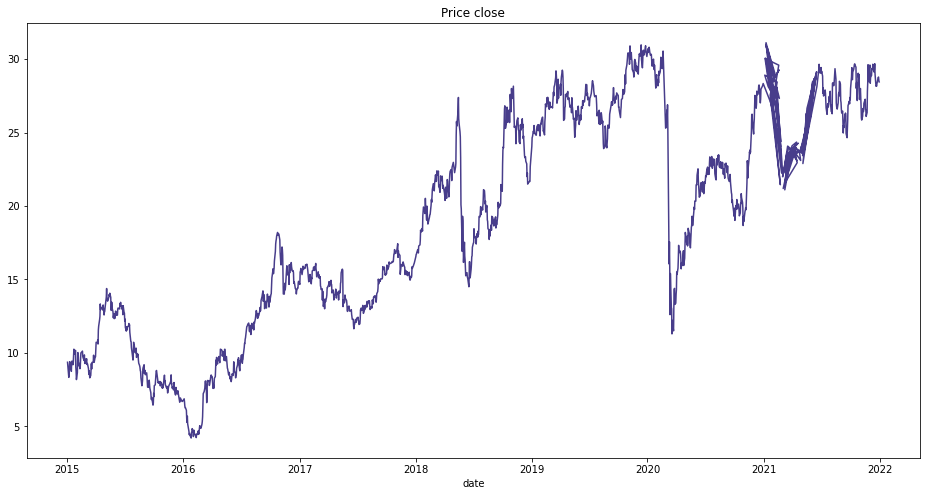

In [16]:
# Plot the dataframe
plt.figure(figsize=(16,8))
plt.title('Price close')
plt.plot(df_petro_cls['preco_fechamento'], color='darkslateblue' )
plt.xlabel('date');


# Data Train and Test

In [17]:
# Data analysis
qtt_rows = len(df_petro_cls)

r_train = round(.70*qtt_rows)

r_test = qtt_rows - r_train

info = (
    f'Train = 0:{r_train} | '
    f'Test = {r_train}:{r_train + r_test}'
    )
info

'Train = 0:1211 | Test = 1211:1730'

# Normalize and Reescale 

In [18]:
# Normalizing
std = StandardScaler()
df_scaled = std.fit_transform(df_petro_cls)

# Separating into Train and Test

In [19]:
train = df_scaled[:qtt_rows]

test = df_scaled[r_train: r_train+r_test]

print(len(train), len(test))

1730 519


In [20]:
# Convert an array of values into a df matrix

def create_df(df, steps=1):
    dataX, dataY = [], []
    for i in range(len(df)-steps-1):
        a = df[i:(i+steps), 0]
        dataX.append(a)
        dataY.append(df[i+steps,0])
    return np.array(dataX), np.array(dataY)

# dexa os valores formatados no padrão que o LSTM espera para aprender

In [21]:
# gerando os dados de treino e teste

steps = 15
X_train, Y_train = create_df(train, steps)
X_test, Y_test = create_df(test, steps)

In [22]:
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)


(1714, 15)
(1714,)
(503, 15)
(503,)


In [23]:
# Gerando os dados no formato que o modelo espera
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_train.shape[0] → 1714 linhas de treino | X_train.shape[1] → 15 dias de treino
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Model Apply

In [24]:
# Camadas da Rede Neural
model = Sequential()
model.add(LSTM(35, return_sequences=True, input_shape=(steps,1))) #1ª camada
#LSTM(35) → qtt de neuronios usados | input_shape=(steps,1) → qtt de dias a ser previsto e retornado
model.add(LSTM(35, return_sequences=True)) #2ª camada
model.add(LSTM(35)) #3ª camada
model.add(Dropout(0.2)) 
#Dropout evita o overfit do treinamento
model.add(Dense(1)) #retonrnando um unico resultado


2022-04-06 13:30:55.226383: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-06 13:30:55.226425: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-06 13:30:55.226456: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2022-04-06 13:30:55.229299: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 35)            5180      
                                                                 
 lstm_1 (LSTM)               (None, 15, 35)            9940      
                                                                 
 lstm_2 (LSTM)               (None, 35)                9940      
                                                                 
 dropout (Dropout)           (None, 35)                0         
                                                                 
 dense (Dense)               (None, 1)                 36        
                                                                 
Total params: 25,096
Trainable params: 25,096
Non-trainable params: 0
_________________________________________________________________


In [26]:
# treinamento do modelo
validation = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=15, verbose=2)

Epoch 1/100
115/115 - 8s - loss: 0.1310 - val_loss: 0.0837 - 8s/epoch - 74ms/step
Epoch 2/100
115/115 - 3s - loss: 0.0510 - val_loss: 0.0825 - 3s/epoch - 24ms/step
Epoch 3/100
115/115 - 3s - loss: 0.0431 - val_loss: 0.0522 - 3s/epoch - 23ms/step
Epoch 4/100
115/115 - 3s - loss: 0.0346 - val_loss: 0.0404 - 3s/epoch - 23ms/step
Epoch 5/100
115/115 - 3s - loss: 0.0319 - val_loss: 0.0490 - 3s/epoch - 23ms/step
Epoch 6/100
115/115 - 3s - loss: 0.0308 - val_loss: 0.0393 - 3s/epoch - 23ms/step
Epoch 7/100
115/115 - 3s - loss: 0.0306 - val_loss: 0.0432 - 3s/epoch - 23ms/step
Epoch 8/100
115/115 - 3s - loss: 0.0287 - val_loss: 0.0335 - 3s/epoch - 23ms/step
Epoch 9/100
115/115 - 3s - loss: 0.0282 - val_loss: 0.0369 - 3s/epoch - 23ms/step
Epoch 10/100
115/115 - 3s - loss: 0.0261 - val_loss: 0.0355 - 3s/epoch - 23ms/step
Epoch 11/100
115/115 - 3s - loss: 0.0258 - val_loss: 0.0332 - 3s/epoch - 23ms/step
Epoch 12/100
115/115 - 3s - loss: 0.0262 - val_loss: 0.0336 - 3s/epoch - 23ms/step
Epoch 13/100


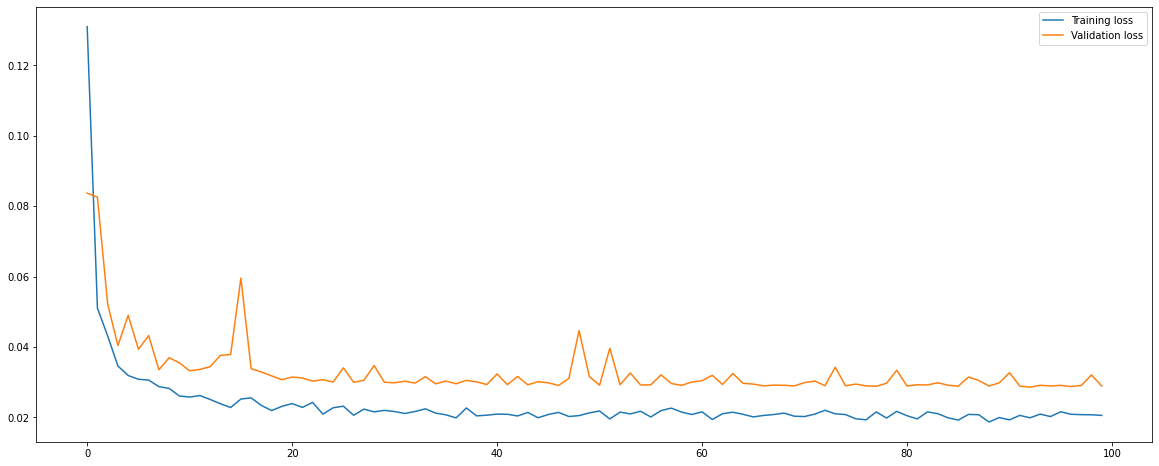

In [27]:
plt.figure(figsize=(20,8))
plt.plot(validation.history['loss'], label='Training loss')
plt.plot(validation.history['val_loss'], label='Validation loss')
plt.legend();

In [28]:
# Prediction
prev = model.predict(X_test)
prev = std.inverse_transform(prev)
prev

array([[30.161652],
       [30.119635],
       [30.230124],
       [30.278034],
       [30.242933],
       [30.317665],
       [30.475368],
       [30.474974],
       [30.42133 ],
       [30.529978],
       [30.489063],
       [30.583231],
       [30.590162],
       [30.552658],
       [30.501175],
       [30.428251],
       [30.39684 ],
       [30.264778],
       [30.042564],
       [29.879082],
       [29.85286 ],
       [29.8542  ],
       [29.745914],
       [29.608065],
       [29.618942],
       [29.510433],
       [29.024958],
       [29.002169],
       [28.910963],
       [28.901262],
       [28.731651],
       [28.551441],
       [28.609047],
       [28.532078],
       [28.814487],
       [28.867437],
       [29.02552 ],
       [29.23638 ],
       [29.584204],
       [29.670427],
       [29.673935],
       [29.662207],
       [29.757847],
       [30.030169],
       [29.980068],
       [29.76629 ],
       [28.572447],
       [27.151957],
       [26.157614],
       [26.151768],


In [29]:
# Predict the next 10 days
lenght_test = len(test)
lenght_test

519

In [30]:
# Get the last days to step
days_input_steps =lenght_test - steps
days_input_steps

504

In [31]:
# Transform in array
input_steps = test[days_input_steps:]
input_steps = np.array(input_steps).reshape(1, -1)
input_steps

array([[1.41048896, 1.4595649 , 1.43502693, 1.3873142 , 1.41185218,
        1.46501778, 1.36959234, 1.25644502, 1.2618979 , 1.25644502,
        1.27961977, 1.33687504, 1.3409647 , 1.30824741, 1.29597842]])

In [32]:
# Return in list
list_output_steps = list(input_steps)
list_output_steps = list_output_steps[0].tolist()
list_output_steps

[1.4104889554776525,
 1.459564899170591,
 1.4350269273241218,
 1.3873142042893207,
 1.4118521761357898,
 1.46501778180314,
 1.3695923357335371,
 1.2564450211081513,
 1.2618979037406999,
 1.2564450211081513,
 1.279619772296483,
 1.336875039938245,
 1.3409647019126567,
 1.3082474061173641,
 1.2959784201941293]

In [33]:
#Loop to preview the next 10 days
pred_output = [] #→ recebe os dias a serem previstos
i = 0
n_future = 10
while(i<n_future):
    if(len(list_output_steps) > steps):
       input_steps = np.array(list_output_steps[1:])
       print('Day {}. Value Entrance → {}'.format(i, input_steps))
       input_steps = input_steps.reshape(1, -1)
       input_steps = input_steps.reshape((1, steps, 1))
       #print(input_steps)
       pred = model.predict(input_steps, verbose=0)
       print('Day {}. Value Predict → {}'.format(i, pred))
       list_output_steps.extend(pred[0].tolist())
       list_output_steps = list_output_steps[1:]
       #print(list_output_steps)
       pred_output.extend(pred.tolist())
       i = i+1
       
    else:
       input_steps = input_steps.reshape((1, steps, 1))
       pred= model.predict(input_steps, verbose=0)
       print(pred[0])
       list_output_steps.extend(pred[0].tolist())
       print(len(list_output_steps))
       pred_output.extend(pred.tolist())
       i = i+1
       
print(pred_output)
       
       

[1.3167088]
16
Day 1. Value Entrance → [1.4595649  1.43502693 1.3873142  1.41185218 1.46501778 1.36959234
 1.25644502 1.2618979  1.25644502 1.27961977 1.33687504 1.3409647
 1.30824741 1.29597842 1.3167088 ]
Day 1. Value Predict → [[1.3258919]]
Day 2. Value Entrance → [1.43502693 1.3873142  1.41185218 1.46501778 1.36959234 1.25644502
 1.2618979  1.25644502 1.27961977 1.33687504 1.3409647  1.30824741
 1.29597842 1.3167088  1.32589185]
Day 2. Value Predict → [[1.3340989]]
Day 3. Value Entrance → [1.3873142  1.41185218 1.46501778 1.36959234 1.25644502 1.2618979
 1.25644502 1.27961977 1.33687504 1.3409647  1.30824741 1.29597842
 1.3167088  1.32589185 1.33409894]
Day 3. Value Predict → [[1.3424929]]
Day 4. Value Entrance → [1.41185218 1.46501778 1.36959234 1.25644502 1.2618979  1.25644502
 1.27961977 1.33687504 1.3409647  1.30824741 1.29597842 1.3167088
 1.32589185 1.33409894 1.34249294]
Day 4. Value Predict → [[1.3510069]]
Day 5. Value Entrance → [1.46501778 1.36959234 1.25644502 1.2618979 

In [34]:
# transform exit
prev = std.inverse_transform(pred_output)
prev = np.array(prev).reshape(1, -1)
list_output_prev = list(prev)
list_output_prev = prev[0].tolist()
list_output_prev

[28.60206916693207,
 28.66943206337257,
 28.72963568997861,
 28.791210482469644,
 28.85366498980781,
 28.918291675754602,
 28.9747648217067,
 29.02477564885133,
 29.07896118641367,
 29.1330094324939]

In [35]:
# format exit (date to predict)
dates = pd.to_datetime(df_petro['data_pregao'])
predict_dates = pd.date_range(list(dates)[-1] + pd.DateOffset(1), periods=10, freq='b').to_list()
predict_dates

[Timestamp('2021-12-31 00:00:00', freq='B'),
 Timestamp('2022-01-03 00:00:00', freq='B'),
 Timestamp('2022-01-04 00:00:00', freq='B'),
 Timestamp('2022-01-05 00:00:00', freq='B'),
 Timestamp('2022-01-06 00:00:00', freq='B'),
 Timestamp('2022-01-07 00:00:00', freq='B'),
 Timestamp('2022-01-10 00:00:00', freq='B'),
 Timestamp('2022-01-11 00:00:00', freq='B'),
 Timestamp('2022-01-12 00:00:00', freq='B'),
 Timestamp('2022-01-13 00:00:00', freq='B')]

In [36]:
# New DataFrame 
forecast_dates = []
for i in predict_dates:
    forecast_dates.append(i.date())
    
df_forecast = pd.DataFrame({'data_pregao':np.array(forecast_dates), 'preco_fechamento':list_output_prev})
df_forecast['data_pregao'] = pd.to_datetime(df_forecast['data_pregao'])

In [37]:
df_forecast = df_forecast.set_index(pd.DatetimeIndex(df_forecast['data_pregao'].values))
df_forecast.drop('data_pregao', axis=1, inplace=True)
df_forecast

    

,preco_fechamento
2021-12-31,28.602069
2022-01-03,28.669432
2022-01-04,28.729636
2022-01-05,28.791210
2022-01-06,28.853665
2022-01-07,28.918292
2022-01-10,28.974765
2022-01-11,29.024776
2022-01-12,29.078961
2022-01-13,29.133009


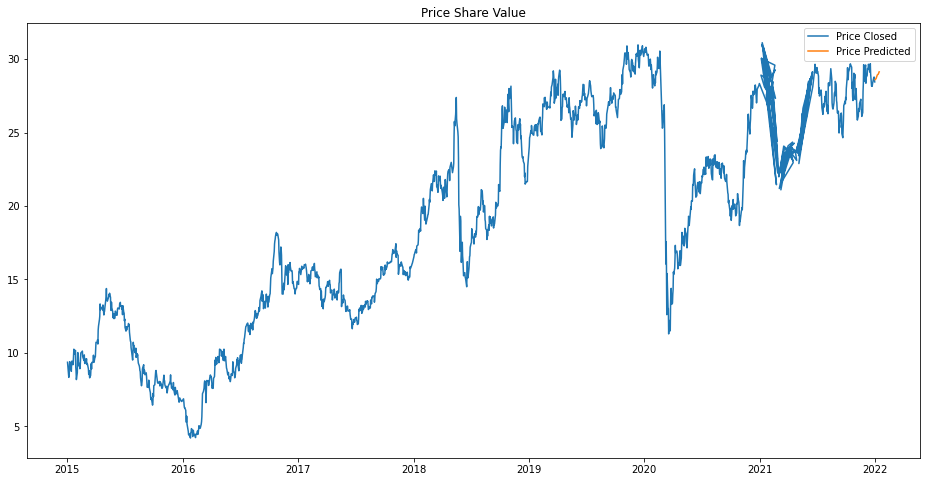

In [38]:
plt.figure(figsize=(16,8))
plt.title('Price Share Value')
plt.plot(df_petro_cls['preco_fechamento'])
plt.plot(df_forecast['preco_fechamento'])
plt.legend(['Price Closed', 'Price Predicted'])
plt.show();


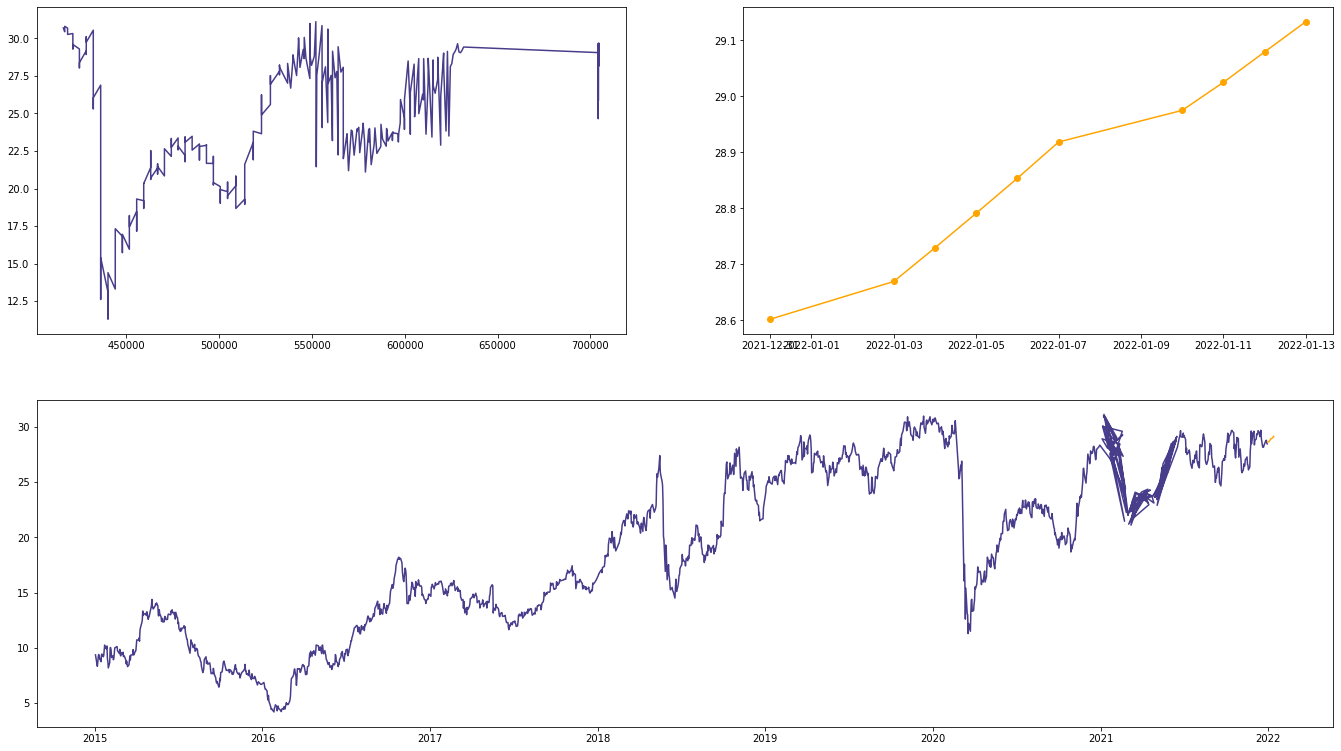

In [40]:
b = df_petro[df_petro['data_pregao'] > '2020-01-01']
fig = plt.figure(figsize=(18, 10))
plt.subplots_adjust(bottom = 0., left = 0, top = 1., right = 1)

# Create first axes, the top-left plot with green plot
sub1 = fig.add_subplot(2,2,1) # two rows, two columns, fist cell
plt.plot(b['preco_fechamento'], color='darkslateblue')
# Create second axes, the top-left plot with orange plot
sub2 = fig.add_subplot(2,2,2) # two rows, two columns, second cell
plt.plot(df_forecast['preco_fechamento'], label='Predict Value', color='orange', marker='o');

# Create third axes, a combination of third and fourth cell
sub3 = fig.add_subplot(2,2,(3,4)) # two rows, two colums, combined third and fourth cell
plt.plot(df_petro_cls['preco_fechamento'],color='darkslateblue')
plt.plot(df_forecast['preco_fechamento'], color='orange');

# Comparando os Dados Reais de 2022 e minha Previsão

In [42]:
df_2022 = pd.read_csv('../data/b3_bovespa_2022.csv')

In [43]:
df_2022['data_pregao'] = pd.to_datetime(df_2022['data_pregao'], format='%Y-%m-%d')

In [44]:
df = df_2022.copy()

In [45]:
df = df[df['sigla_acao'] == 'PETR4']
df = df[df['data_pregao'] <= '2022-01-13']

In [46]:
# set to index with date
df = df.set_index(pd.DatetimeIndex(df['data_pregao'].values))
df.drop('data_pregao', axis=1)

,codbdi,sigla_acao,nome_acao,preco_abertura,preco_maximo,preco_minimo,preco_fechamento,qtd_negocios,volume_negocios
2022-01-03,2,PETR4,PETROBRAS,28.54,29.22,28.53,29.09,52704700,15
2022-01-04,2,PETR4,PETROBRAS,29.16,29.40,28.91,29.20,51739200,15
2022-01-05,2,PETR4,PETROBRAS,29.19,29.27,27.94,28.07,78459800,22
2022-01-06,2,PETR4,PETROBRAS,28.29,28.65,27.84,28.05,61163100,17
2022-01-07,2,PETR4,PETROBRAS,28.11,28.29,27.82,28.18,47507600,13
2022-01-10,2,PETR4,PETROBRAS,27.99,28.24,27.72,28.01,37455200,10
2022-01-11,2,PETR4,PETROBRAS,28.10,29.07,27.85,28.84,73623800,21
2022-01-12,2,PETR4,PETROBRAS,28.95,29.91,28.95,29.72,81378200,24
2022-01-13,2,PETR4,PETROBRAS,29.53,30.63,29.50,30.32,76717500,23


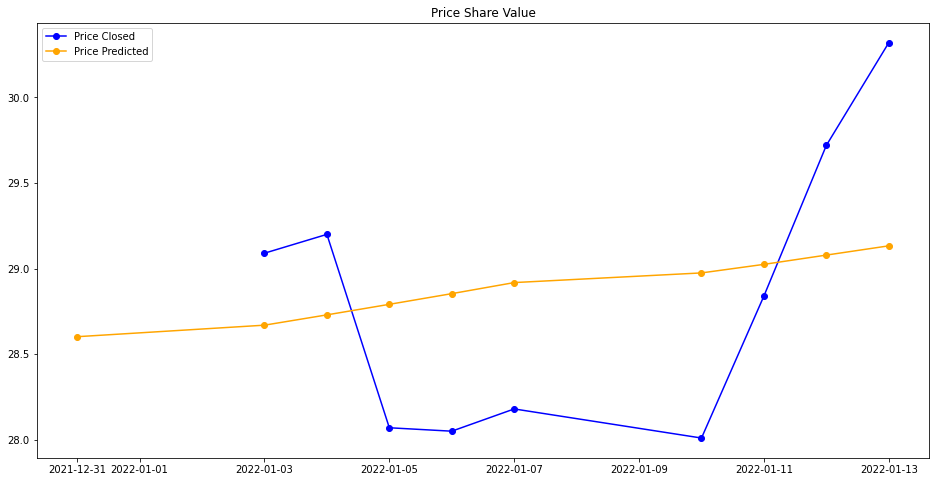

In [47]:
plt.figure(figsize=(16,8))
plt.title('Price Share Value')
plt.plot(df['preco_fechamento'],label='Real Value', color='blue', marker='o')
plt.plot(df_forecast['preco_fechamento'],label='Predict Value', color='orange', marker='o')
plt.legend(['Price Closed', 'Price Predicted'])
plt.show();
